# T2 Practica 2: Modelos de difusión en espacio latente y generación condicionada de imágenes (text-to-image). Stable Diffusion v1.4 como caso de estudio (alumnos)

Stable Diffusion es un modelo de difusión latente de texto a imagen creado por investigadores e ingenieros de CompVis, Stability AI y LAION. Fue entrenado con imágenes de 512x512 provenientes de un subconjunto de la base de datos LAION-5B. Este modelo utiliza un codificador de texto CLIP ViT-L/14 congelado para condicionar el modelo a partir de prompts de texto. Con su UNet de 860M y un codificador de texto de 123M, el modelo es relativamente ligero y puede ejecutarse en muchas GPU de ordenadores domésticos. Consulta la [tarjeta del modelo](https://huggingface.co/CompVis/stable-diffusion) para más información.

Este cuaderno de Colab muestra cómo ejecutar un pipeline de inferencia de Stable Diffusion, utilizando pesos ya entrenados, con la biblioteca [Hugging Face Diffusers](https://github.com/huggingface/diffusers)

### Setup

In [5]:
import torch

In [6]:
#%pip install -qq -U diffusers transformers scipy ftfy

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


### Intro (desplegar para leer texto introductorio)

HuggingFace proporciona pipelines para modelos entrenados listos para ejecutar en muy pocas lineas de código, simplemente como una caja negra. Pero el objetivo de esta práctica es comprender a fondo cada uno de los componentes de este tipo de modelos, complementando las clases de teoría.

Stable Diffusion está basado en un tipo particular de modelo de difusión llamado **Latent Diffusion**, propuesto en [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Como se ha visto en las últimas clases, los modelos de difusión son sistemas de *machine learning* entrenados para realizar **denoising** a partir de una muestra de ruido puro, es decir, limpiar el ruido paso a paso, hasta obtener una muestra de interés (por ejemplo, una *imagen*). Han demostrado alcanzar calidad estado-del-arte en generación de imágenes. Pero tienen un inconveniente: el proceso inverso de difusión para realizar dicho denoising es lento.  Además, consumen mucha memoria porque trabajan en el espacio de píxeles, lo cual se vuelve muy costoso al generar imágenes de alta resolución.  

La difusión latente reduce la memoria y el coste computacional aplicando el proceso de difusión en un espacio latente de menor dimensión, en lugar del espacio de píxeles real. Ésta es la diferencia clave: **en la difusión latente el modelo aprende a generar representaciones latentes (comprimidas) de las imágenes.**

Hay tres componentes principales:

1. Un autoencoder (VAE).  
2. Un U-Net  
3. Un codificador de texto, p. ej. el *Text Encoder* de CLIP.

**1. El autoencoder (VAE)**

El VAE tiene dos partes: *encoder* y *decoder*.  
El encoder convierte la imagen en una representación latente de baja dimensión (entrada para el U-Net).  
El decoder transforma esa representación latente nuevamente en imagen.  

- Durante el **entrenamiento**, el encoder genera las representaciones latentes que se usan en el proceso directo de difusión (agregando ruido paso a paso).  
- Durante la **inferencia**, los latentes limpios obtenidos por el proceso inverso (a partir de una muestra inicialmente ruidosa) se convierten en imágenes (Limpias) con el decoder.  

En inferencia **solo necesitamos el decoder del VAE**.

**2. Modelo U-Net**

El U-Net predice el **ruido** total presente. No se puede limpiar todo el ruido *de golpe*, sino que se debe ir paso a paso para lograr calidad de generación adecuada, dado que estas predicciones no son exactas y debemos realizar esa iteración progresiva; por ahora el approach más rápido que hemos visto era DDIM. Para no perder información al reducir resolución, se añaden *skip connections* entre encoder y decoder.  

Además, la U-Net de Stable Diffusion puede condicionarse a partir de *text embeddings* basados en el prompt que definamos con nuestro objetivo a generar, a través de capas de *cross-attention* (tanto en encoder como en decoder) que permiten captar esta información.

**3. Text-encoder para prompts de condicionamiento**

El text encoder convierte el *prompt* (“un astronauta montando un caballo”) en un espacio de embeddings entendible para el U-Net.  
Suele ser un encoder tipo *transformer* que mapea secuencias de tokens en secuencias de *text embeddings*.  

Stable Diffusion **no** entrena este encoder; usa directamente el de CLIP ya entrenado: [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

Concretamente, utilizan un CLIP ViT-L/14 como text-encoder. La salida no agrupada (non-pooled output) del encoder se introduce en la red UNet que opera en espacio latente a través de mecanismo de cross-attention *(visto en la teoría, revisar si hay dudas)*

**¿Por qué la difusión latente es rápida y eficiente?**

Porque el U-Net trabaja en un espacio de baja dimensión, reduciendo drásticamente memoria y cómputo. Ejemplo: el autoencoder de Stable Diffusion reduce por un factor de 8 la resolución en pixeles, y pasa de 3 canales (RGB) a 4 en el espacio latente. Es decir, una imagen `(3, 512, 512)` se convierte en `(4, 64, 64)` en el espacio latente. Esto permite generar imágenes de `512 × 512` muy rápido, incluso en GPUs básicas.

**Stable Diffusion durante la inferencia**

Juntando todas las piezas, veamos el pipeline completo:

<p align="left">
<img src="https://i.ibb.co/S7Z9K4Qt/Screenshot-2025-09-20-at-09-25-01.png"  alt="sd-pipeline" width="500"/>
</p>

El modelo recibe:  
- una muestra de ruido en espacio latente, será la semilla para la generación → utilizaremos representaciones latentes aleatorias de tamaño `64×64` (ya no son pixeles... sino dimensiones en el latente).  
- un prompt de texto → convertido en embeddings `77×768` con CLIP.  

Después, el U-Net limpia iterativamente las representaciones latentes condicionándose en los embeddings de texto.  Se toma la predicción de ruido total presente en cada paso y se retira parcialmente, en base al *scheduler*, para calcular la muestra latente del siguiente paso (un poco menos ruidoso el paso previo)... hasta llegar a la imagen totalmente limpia

El scheduler para muestrear por defecto en este modelo es [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py).
Disponemos también de otras opciones como [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py), capaz de conseguir gran calidad en menos pasos. Veremos en detalle esta y otras opciones de muestreo avanzado en la última parte del tema de Difusión, junto con la formulación SDE/PF-ODE.

Por ahora, no nos preocuparemos demasiado por los detalles sobre la implementación de estos muestreadores avanzados, habrá tiempo de verlos más adelante junto con la teoría correspondiente. Pero si que ejecutaremos varios de ellos para hacer una comparativa a alto nivel sobre su calidad y performance.

El proceso de denoising toma múltiples pasos hasta obtener latentes "limpios" y finalmente, el decoder del VAE convierte los latentes en la imagen final, muestras realistas generadas por el modelo.


### Construyendo el pipeline por componentes



Se va a construir paso a paso el *pipeline* de Stable Diffusion 1.4. Esto es útil para profundizar en ciertas funciones o cambiar componentes.
En este notebook usamos la versión 1.4 de Stable Diffusion ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), pero hay otras variantes que puedes probar.

El [modelo preentrenado](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) incluye todos los componentes de un pipeline de difusión:

- `text_encoder`: Stable Diffusion usa CLIP, otros podrían usar BERT.  
- `tokenizer`: debe coincidir con el encoder.  
- `scheduler`: algoritmo de planificación para el ruido.  
- `unet`: genera las representaciones latentes.  
- `vae`: decodifica los latentes en imágenes reales.  

Podemos cargar cada componente indicando la carpeta (`subfolder`).

In [8]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

# 1. VAE para decodificar los latentes en imágenes (opcional: torch.float16)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Tokenizador y encoder de texto
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. U-Net para generar los latentes
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# si queremos cargar en precision fp16
# text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16)
# vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16)
# unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16)

In [9]:
from diffusers import AutoencoderKL

total_params = sum(p.numel() for p in vae.parameters())
print(f"Total parámetros VAE: {total_params/1e6:.1f} M")

Total parámetros VAE: 83.7 M


In [10]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

Analicemos la VRAM utilizada solo para alojar los pesos

In [ ]:
# @title
print("VAE:", next(vae.parameters()).dtype)
print("Text Encoder:", next(text_encoder.parameters()).dtype)
print("U-Net:", next(unet.parameters()).dtype)

# Función para ver memoria
def print_vram(prefix=""):
    allocated = torch.cuda.memory_allocated() / 1024**2  # MB
    reserved  = torch.cuda.memory_reserved() / 1024**2   # MB
    print(f"{prefix} VRAM usada: {allocated:.2f} MB | Reservada: {reserved:.2f} MB")

print_vram("Después de cargar modelos:")

VAE: torch.float32
Text Encoder: torch.float32
U-Net: torch.float32
Después de cargar modelos: VRAM usada: 0.00 MB | Reservada: 0.00 MB


Analicemos el tamaño del modelo en cuanto a número de parámetros y hagamos estimación de tamaño de los pesos en la precisión elegida (fp32 o fp16)

In [ ]:
# @title
import torch

def count_parameters(model, name="model"):
    """Cuenta parámetros totales y entrenables"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name:<25} | Total: {total/1e6:,.1f} M | Entrenables: {trainable/1e6:,.1f} M")
    return total

def estimate_size(num_params, dtype="fp32"):
    """Estima tamaño en bytes de un modelo dado el número de parámetros"""
    if dtype == "fp32":
        bytes_per_param = 4
    elif dtype in ["fp16", "bf16"]:
        bytes_per_param = 2
    elif dtype == "int8":
        bytes_per_param = 1
    else:
        raise ValueError(f"Precisión desconocida: {dtype}")
    return num_params * bytes_per_param

def pretty_size(n_bytes):
    """Convierte bytes a GB decimal (1e9) y GiB binario (1024³)"""
    gb = n_bytes / 1e9        # decimal
    gib = n_bytes / (1024**3) # binario
    return f"{gb:.2f} GB, {gib:.2f} GiB"

# --- Ejemplo con tus modelos  ---
vae_params   = count_parameters(vae, "AutoencoderKL (VAE)")
clip_params  = count_parameters(text_encoder, "CLIPTextModel")
unet_params  = count_parameters(unet, "UNet2DConditionModel")

total_all = vae_params + clip_params + unet_params
print("\n--- Total aproximado de parámetros ---")
print(f"Stable Diffusion v1.4 completo ≈ {total_all/1e9:.2f} B parámetros")

print("\n--- Estimación de tamaños ---")
for name, params in [
    ("AutoencoderKL (VAE)", vae_params),
    ("CLIPTextModel", clip_params),
    ("UNet2DConditionModel", unet_params),
    ("TOTAL", total_all)
]:
    size_fp32 = estimate_size(params, "fp32")
    size_fp16 = estimate_size(params, "fp16")
    print(f"{name:<25} | FP32: {pretty_size(size_fp32)} | FP16: {pretty_size(size_fp16)}")

AutoencoderKL (VAE)       | Total: 83.7 M | Entrenables: 83.7 M
CLIPTextModel             | Total: 123.1 M | Entrenables: 123.1 M
UNet2DConditionModel      | Total: 859.5 M | Entrenables: 859.5 M

=== Total aproximado de parámetros ===
Stable Diffusion v1.4 completo ≈ 1.07 B parámetros

=== Estimación de tamaños ===
AutoencoderKL (VAE)       | FP32: 0.33 GB, 0.31 GiB | FP16: 0.17 GB, 0.16 GiB
CLIPTextModel             | FP32: 0.49 GB, 0.46 GiB | FP16: 0.25 GB, 0.23 GiB
UNet2DConditionModel      | FP32: 3.44 GB, 3.20 GiB | FP16: 1.72 GB, 1.60 GiB
TOTAL                     | FP32: 4.26 GB, 3.97 GiB | FP16: 2.13 GB, 1.99 GiB


Podemos ver que el archivo .safetensors de la unet (accesible también desde HuggingFace Diffusers) con los pesos en fp32 coincide con la estimación teórica (3.44 GB = 3.2 GiB)

Definimos los parámetros de generación de cara a pasos posteriores.  

* `guidance_scale = 7.5`, valor recomendado, recordemos que vimos este hiperparámetro en las clases teóricas.
* `num_inference_steps = 25`, después veremos la influencia con diferentes schedulers, utilizaremos DDIM y otros más avanzados capaces de generar resultados de calidad decente en esta cantidad de pasos
* dimensiones de imagen a generar: 512*512px, en linea con el diseño de Stable Diffusion v1.4
* prompt de prueba para la generación: empecemos con `"a photograph of an astronaut riding a horse"`, despues podeis experimentar
* tamaño de batch para generar en paralelo, en principio `batch_size = 1`
* definir manualmente semilla del generador aleatorio para reproducibilidad

In [13]:
# Texto que queremos usar como prompt para guiar la generación
prompt = ["a photograph of an astronaut riding a horse"]

# Tamaño de la imagen de salida.
# Stable Diffusion v1.4 está entrenado con imágenes 512x512,
# por lo que este es el tamaño "óptimo" por defecto.
height = 512
width = 512

# Número de pasos de denoising en el muestreo.
# A mayor número, más calidad/detalle, pero más lento.
num_inference_steps = 25

# Escala de classifier-free guidance (CFG).
# Controla cuánto se ajusta la generación al prompt.
# Valores altos → imágenes más fieles al prompt, pero menos creativas/diversas.
guidance_scale = 7.5

# Semilla para el generador aleatorio.
# Fijar la seed permite reproducir exactamente la misma imagen.
generator = torch.manual_seed(32)

# Número de imágenes que se van a generar en paralelo en un mismo batch.
batch_size = 1

Primero obtenemos los embeddings de texto del prompt, que condicionarán el U-Net. Utilizaremos el tokenizer definido previamente. De acuerdo con documentación de HF para [CLIPTokenizer](https://huggingface.co/docs/transformers/en/model_doc/clip): *Construct a CLIP tokenizer. Based on byte-level Byte-Pair-Encoding. This tokenizer inherits from [PreTrainedTokenizer](https://huggingface.co/docs/transformers/v4.56.2/en/main_classes/tokenizer#transformers.PreTrainedTokenizer) which contains most of the main methods. Users should refer to this superclass for more information regarding those methods.*

**Tarea 1: Dado un *prompt* en lenguaje natural, debes tokenizar el texto y obtener sus representaciones numéricas (embeddings) usando un *text encoder*.**  

**1. Utiliza `tokenizer(...)` para transformar el *prompt* en tensores. Inspecciona el método call en la [documentación] (https://huggingface.co/docs/transformers/v4.56.2/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__) de PreTrainedTokenizer y asegurate de definir adecuadamente los parámetros para:**  

**- Rellenar hasta la longitud máxima permitida. `(padding)`**  se añaden tokens especiales `[PAD]` para que todas las secuencias tengan la misma longitud posibilitando trabajar con batches.  

**- Truncar si el texto es más largo que el máximo. `(max_length, truncation)`**  Los modelos tienen un límite fijo de tokens que pueden procesar (por ejemplo, 77 en CLIP). Si un *prompt* excede ese límite, se recorta.  

**- Devolver tensores de PyTorch `(return_tensors)`**   

**2. Ejecuta el modelo dentro de un bloque `torch.no_grad()` para no calcular gradientes.**  

**3. Pasa los *input IDs* al `text_encoder` y guarda la salida en una variable llamada `text_embeddings`.**  

Obtendrás una matriz de vectores (`text_embeddings`) que representa semánticamente el *prompt* y que luego podrá condicionar a otro modelo (por ejemplo, la U-Net de difusión).

In [14]:
text_inputs = tokenizer(
    [prompt[0]] * batch_size,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
    ).to(device)
cond_embeddings = text_encoder(text_inputs.input_ids).last_hidden_state

También calculamos los *unconditional embeddings* (texto vacío) para el *classifier-free guidance*.  
Deben tener la misma forma que los `text_embeddings`.

In [15]:
uncond_inputs = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
    ).to(device)
uncond_embeddings = text_encoder(uncond_inputs.input_ids).last_hidden_state

 **Tarea 2: Concatenamos `text_embeddings` y `uncond_embeddings` para evitar dos *forward passes*.	Se construye un batch de tamaño 2.	La U-Net recibe ambas condiciones al mismo tiempo (paraleliza).	Así, con un solo forward pass, separando el resultado de la U-Net en dos partes, obtenemos la predicción cond y uncond, combinadas adecuadamente con la fórmula de Classifier Free Guidance empuja generación hacia el prompt.**

In [16]:
text_embeddings =   torch.cat([uncond_embeddings, cond_embeddings], dim=0)

**Tarea 3: En este paso inicializamos el *tensor de latentes*, que servirá como punto de partida del proceso de difusión.**  

- Utiliza **`torch.randn(...)`** para generar un tensor lleno de valores aleatorios con distribución normal (media 0, varianza 1).  
- **Define una forma `(batch_size, unet.in_channels, height // 8, width // 8)`**, corresponde al espacio latente donde trabaja la U-Net:  
  - `batch_size`: número de imágenes a generar en paralelo.  
  - `unet.in_channels`: canales de entrada de la U-Net (generalmente 4 en Stable Diffusion).  
  - `height // 8`, `width // 8`: dimensiones reducidas de la imagen, porque el modelo opera en un espacio comprimido (factor de 8).  
- **`generator=generator`** asegura que la aleatoriedad sea reproducible si se fija una semilla.  
- Finalmente, mueve el tensor al dispositivo adecuado (GPU o CPU) para que el modelo pueda usarlo.  


In [17]:
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(device)

C:\Users\Asus\AppData\Local\Temp\ipykernel_2608\1277680191.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(device)


Comprobamos la forma

In [18]:
latents.shape

torch.Size([1, 4, 64, 64])

Ahora inicializamos el scheduler con `num_inference_steps`. En primera instanacia vamos a utilizar `PNDMScheduler` que es el que incorpora por defecto el pipeline de SD1.4. Veremos más detalle sobre este muestreador cuando lleguemos a la parte final del T2, la sección de ODE Solvers. Por ahora, no os preocupéis por los detalles de su implementación, simplemente utilizar este muestreador del mismo modo que utilizabais, por ejemplo, DDIM en la práctica anterior.

In [19]:
from diffusers import PNDMScheduler
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps, device=device)

Antes de iniciar el muestreo, los latentes iniciales deben escalarse por `scheduler.init_noise_sigma`.

En forma matemática:

$$
x_{T} = init\_noise\_sigma \cdot z, \quad z \sim \mathcal{N}(0, I)
$$

De este modo, el ruido de partida tiene la misma varianza que en el primer paso del schedule:

$$
\mathrm{Var}[x_{T}] = init\_noise\_sigma^2 \, I
$$

Si se omite este escalado (o se usa directamente 1.0), la U-Net puede recibir entradas fuera de la distribución vista en entrenamiento y no ser capaz de realizar el denoising adecuadamente.

El valor `init_noise_sigma` lo determina cada *scheduler* según su discretización de $\{\sigma_t\}$.

En resumen, tenemos que aplicar el escalado de la siguiente celda:

In [20]:
latents = latents * scheduler.init_noise_sigma

**Tarea 4: escribir el bucle de denoising, operando en espacio latente, donde el ruido inicial se transforma progresivamente en una imagen guiada por texto.**

1. **Iterar sobre los timesteps del scheduler:** Usa `for t in tqdm(scheduler.timesteps):` para recorrer todos los pasos de ruido → imagen.

2. **Concatenar los latentes:** Duplica los tensores de latentes con `torch.cat([latents] * 2)`. Esto permite aplicar *classifier-free guidance* sin tener que hacer dos pasadas por la U-Net.

3. **Escalar los latentes según el paso actual:** Llama a `scheduler.scale_model_input(latent_model_input, t)` para normalizar los valores al rango que espera el modelo en ese `timestep`.

4. **Predecir el ruido con la U-Net:** Hazlo dentro de `with torch.no_grad():` para no calcular gradientes. Pasa como entrada: los latentes escalados, el paso `t` y los embeddings de texto. Guarda la salida en `noise_pred`.

5. **Separar ramas condicionada y no condicionada:** Usa `noise_pred.chunk(2)` para obtener: `noise_pred_uncond` (sin prompt),`noise_pred_text` (con prompt).

6. **Aplicar classifier-free guidance (CFG):**
 Combina ambas predicciones con un factor `guidance_scale` (p.ej. 7.5) para controlar cuánto sigue la imagen el texto.

7. **Actualizar los latentes:** Llama a `scheduler.step(noise_pred, t, latents).prev_sample` para obtener `x_{t-1}` a partir de `x_t`.  Asigna el resultado de nuevo a `latents`.


Al final del bucle:
- El tensor `latents` contendrá una representación latente mucho menos ruidosa que el inicial.
- En las celdas posteriores, se decodificará con el **VAE decoder** para obtener la imagen final.

Nota: se sugiere utilizar `tqdm` para representar la barra de progreso

In [21]:
from tqdm.auto import tqdm

# Iteramos sobre todos los pasos de tiempo definidos por el scheduler.
# Cada paso corresponde a una reducción progresiva del ruido.
for t in tqdm(scheduler.timesteps):

  # Concatenamos los latentes para aplicar classifier-free guidance (CFG).
  # En lugar de hacer dos pasadas por la U-Net (una con prompt vacío y otra con el prompt real),
  # duplicamos el batch y así procesamos ambos casos en un solo forward.
  latents_input = torch.cat([latents] * 2, dim=0)

  # Escalamos los latentes según el paso actual.
  # Cada scheduler espera una magnitud distinta de latentes dependiendo de t.
  latents_input = scheduler.scale_model_input(latents_input, t)

  # Predicción del ruido con la U-Net, desactivando el cálculo de gradientes
  # (solo inferencia, más rápido y con menor consumo de memoria).
  with torch.no_grad():
      noise_pred = unet(latents_input, t, encoder_hidden_states=text_embeddings).sample

  # Separamos las predicciones en dos mitades:
  # - noise_pred_uncond: sin condición (prompt vacío)
  # - noise_pred_text: con condición (prompt real)
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

  # Aplicamos classifier-free guidance:
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Usamos el scheduler para calcular el siguiente estado de los latentes:
  # Pasamos de x_t a x_{t-1} usando la predicción de ruido ajustada.
  latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 26/26 [02:25<00:00,  5.58s/it]


Ahora, es el momento de decodificar los latentes con el método decode del VAE, para pasar el latente limpio al espacio de imagen (limpia). Pero antes de decodificar, se debe aplicar un factor de escalado sobre el latente, dividiendo entre `vae.config.scaling_factor`.

Este factor, definido a modo de hiperparámetro en la configuración del VAE, asegura que el espacio latente codificado en el que opera el modelo de difusión tenga aproximadamente varianza unitaria.

Como se puede observar consultando el [config.json](https://huggingface.co/CompVis/stable-diffusion-v1-4/blob/main/vae/config.json) del vae en stable-diffusion-v1-4, se define un `scaling_factor=0.18215`. El procedimiento para deducir este factor es, grosso modo, obtener la desviacion estandar de muchas muestras de imágenes codificadas al latente a través del encoder del VAE, hallando así el factor de escalado a aplicar.

Los latentes de muestras de imagenes se escalan con este factor antes de introducirse en la U-Net, y deben desescalarse al pasar al decoder. Eso mantiene la coherencia entre VAE y U-Net.

Para más información sobre este factor, se puede consultar el apéndice G del paper [Latent Diffusion Models](https://arxiv.org/pdf/2112.10752) o la [discusión en Github](https://github.com/huggingface/diffusers/issues/437) donde responde el autor principal (Rombach)

In [22]:
# Desescalado de latentes
latents = latents / vae.config.scaling_factor 

Ahora sí, estamos en disposición de decodificar la muestra en espacio latente (ya limpia), pasándola por el decoder del VAE para devolver la imagen limpia correspondiente.

**Tarea 5: decodifica utilizando el método [decode del VAE](https://github.com/huggingface/diffusers/blob/v0.35.1/src/diffusers/models/autoencoders/autoencoder_kl.py#L302)**

In [23]:
# Decodificar latentes -> tensor imagen en [-1,1]
images = vae.decode(latents).sample

**Tarea 6: debes convertir el tensor de salida de tu modelo en una imagen PIL visualizable.**

1. **Normaliza** el rango de la imagen de `[-1, 1]` a `[0, 1]`.  
2. **Convierte** el tensor de PyTorch a un array de NumPy. Desactiva el seguimiento de gradientes (`detach`). Pasa el tensor a la CPU (`cpu`). Reordena las dimensiones a `(batch, alto, ancho, canales)`.  
3. **Escala** los valores a `[0, 255]` y cámbialos al tipo `uint8`.  
4. **Crea** imágenes con la librería `PIL.Image`.  
5. **Muestra** al menos una de las imágenes resultantes.

El objetivo es que, partiendo de los tensores producidos por el modelo, obtengas una imagen en un formato estándar (ej. PNG o JPG) que puedas visualizar o guardar.

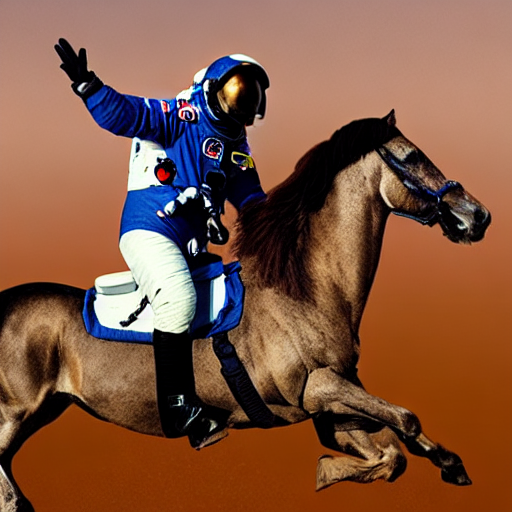

In [ ]:
from PIL import Image
from IPython.display import display

# Normalizar a [0,1] mientras aún es tensor
images = (images / 2 + 0.5).clamp(0, 1)

# Pasar a CPU y reordenar a (B,H,W,C)
images = images.cpu().permute(0, 2, 3, 1).detach().numpy()

# Escalar a [0,255] y convertir a uint8
images = (images * 255).round().astype("uint8")

# Crear objetos PIL.Image
pil_images = [Image.fromarray(image) for image in images]

# Mostrar la primera imagen en Colab/Jupyter
display(pil_images[0])


**Tarea 7: implementa un loop para realizar generación y plotear las evolución de las muestras a lo largo de diferentes steps en el proceso generativo utilizando diferentes schedulers, debes obtener como resultado un plot similar al que se muestra debajo de esta celda de instrucciones.**

La implementación es libre, si lo deseas, puedes usar los pipelines definidos directamente en la librería, sin necesidad de volver a reproducir todos los bloques (text encoder, vae, unet...), queda a libre elección.

Debes parametrizar, por lo menos:

```
* num_inference_steps = 25
* guidance_scale = xx (elige el que consideres, sugerido 7.5 pero puedes experimentar)
* seed = xx (semilla aleatoria simplemente para reproducibilidad)
* steps_to_show = [1, 10, 15, 20, 25]
```
El proceso de muestreo se debe ejecutar **una única vez para cada scheduler**, debiendo extraer las muestras de los pasos intermedios a plotear y no solo el resultado final.

Debes comparar el rendimiento de estas 4 opciones de schedulers para muestreo, si lo deseas puedes incluir alguno más:

```
schedulers = {
    "DDIM": DDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
    "PNDM": PNDMScheduler.from_pretrained(model_id, subfolder="scheduler"),
    "DPM++ 2M Karras": DPMSolverMultistepScheduler.from_pretrained(
        model_id, subfolder="scheduler", algorithm_type="dpmsolver++",
        solver_order=2, use_karras_sigmas=True),
    "UniPC": UniPCMultistepScheduler.from_pretrained(
        model_id, subfolder="scheduler", use_karras_sigmas=True)
}
```

Para ello, utiliza el mismo prompt que hemos usado en el notebook
```
prompt = "a photograph of an astronaut riding a horse"
```
Y realiza una generación en 25 pasos con cada uno de ellos, guardando resultados en pasos intermedios `(steps_to_show)`

En el plot final que generes, junto con la cuadrícula de imágenes, debe incluirse un titulo o etiquetas descriptivas con la siguiente información:
* Prompt utilizado
* Guidance_scale
* Steps
* Modelo utilizado
* Precision utilizada
* Dispositivo utilizado
* Tiempos de muestreo totales en cada scheduler

Puedes ver un ejemplo abajo del formato de resultado final que debes generar... por supuesto las imágenes dependerán de la semilla empleada para el generador.

<a href="https://ibb.co/5X9bzS74"><img src="https://i.ibb.co/hxM3n4q9/Screenshot-2025-09-21-at-15-00-41.png" alt="Screenshot-2025-09-21-at-15-00-41" border="0"></a>

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

from diffusers import (
    DDIMScheduler,
    PNDMScheduler,
    DPMSolverMultistepScheduler,
    UniPCMultistepScheduler,
)

# --- Config  ---
model_id = "CompVis/stable-diffusion-v1-4"
num_inference_steps = 25
guidance_scale = 7.5
seed = 32
steps_to_show = [1, 10, 15, 20, 25]   # columnas del grid

# Dtype y dispositivo coherentes con tus pesos actuales
torch_dtype = next(unet.parameters()).dtype
device_str = "cuda" if torch.cuda.is_available() else "cpu"

# Prompt como string
prompt_str = prompt[0] if isinstance(prompt, (list, tuple)) else str(prompt)

# --- Helper: [-1,1] tensor (3,H,W) -> PIL ---
def to_pil_image(img_tensor: torch.Tensor) -> Image.Image:
    img = (img_tensor.clamp(-1, 1) + 1) / 2.0          # [0,1]
    img = (img * 255).round().byte().permute(1, 2, 0)  # (H,W,3)
    return Image.fromarray(img.cpu().numpy())

text_inputs = tokenizer(
    [prompt_str],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).to(device)

cond_embeddings = text_encoder(text_inputs.input_ids).last_hidden_state  # (1,77,768)

uncond_inputs = tokenizer(
    [""],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).to(device)

uncond_embeddings = text_encoder(uncond_inputs.input_ids).last_hidden_state  # (1,77,768)

text_embeddings = torch.cat([uncond_embeddings, cond_embeddings], dim=0)  # (2,77,768)

# --- Una ejecución por scheduler, guardando snapshots intermedios ---
def run_scheduler(name, scheduler):
    gen = torch.Generator(device=device).manual_seed(seed)

    # Latente 64x64 para imagen 512x512 (factor 8 del VAE)
    latents = torch.randn(
        (1, unet.in_channels, height // 8, width // 8),
        generator=gen, device=device, dtype=torch_dtype
    )

    scheduler.set_timesteps(num_inference_steps, device=device)
    latents = latents * scheduler.init_noise_sigma

    snaps = {}
    t0 = time.time()
    for i, t in enumerate(tqdm(scheduler.timesteps, desc=name)):
        x = torch.cat([latents] * 2, dim=0)          # batch=2 para CFG
        x = scheduler.scale_model_input(x, t)

        with torch.no_grad():
            noise_pred = unet(x, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

        if (i + 1) in steps_to_show:
            with torch.no_grad():
                decoded = vae.decode(latents / vae.config.scaling_factor).sample  # [-1,1]
            snaps[i + 1] = to_pil_image(decoded[0])

    total = time.time() - t0
    return snaps, total

# --- Schedulers a comparar ---
schedulers = {
    "DDIM": DDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
    "PNDM": PNDMScheduler.from_pretrained(model_id, subfolder="scheduler"),
    "DPM++ 2M Karras": DPMSolverMultistepScheduler.from_pretrained(
        model_id, subfolder="scheduler", algorithm_type="dpmsolver++",
        solver_order=2, use_karras_sigmas=True
    ),
    "UniPC": UniPCMultistepScheduler.from_pretrained(
        model_id, subfolder="scheduler", use_karras_sigmas=True
    ),
}

# --- Ejecutar y recolectar resultados ---
samples_by_sched = {}
times_by_sched = {}

for name, sch in schedulers.items():
    snaps, tsec = run_scheduler(name, sch)
    samples_by_sched[name] = snaps
    times_by_sched[name] = tsec


C:\Users\Asus\AppData\Local\Temp\ipykernel_2608\596617496.py:65: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, unet.in_channels, height // 8, width // 8),
UniPC: 100%|██████████| 25/25 [02:30<00:00,  6.03s/it]


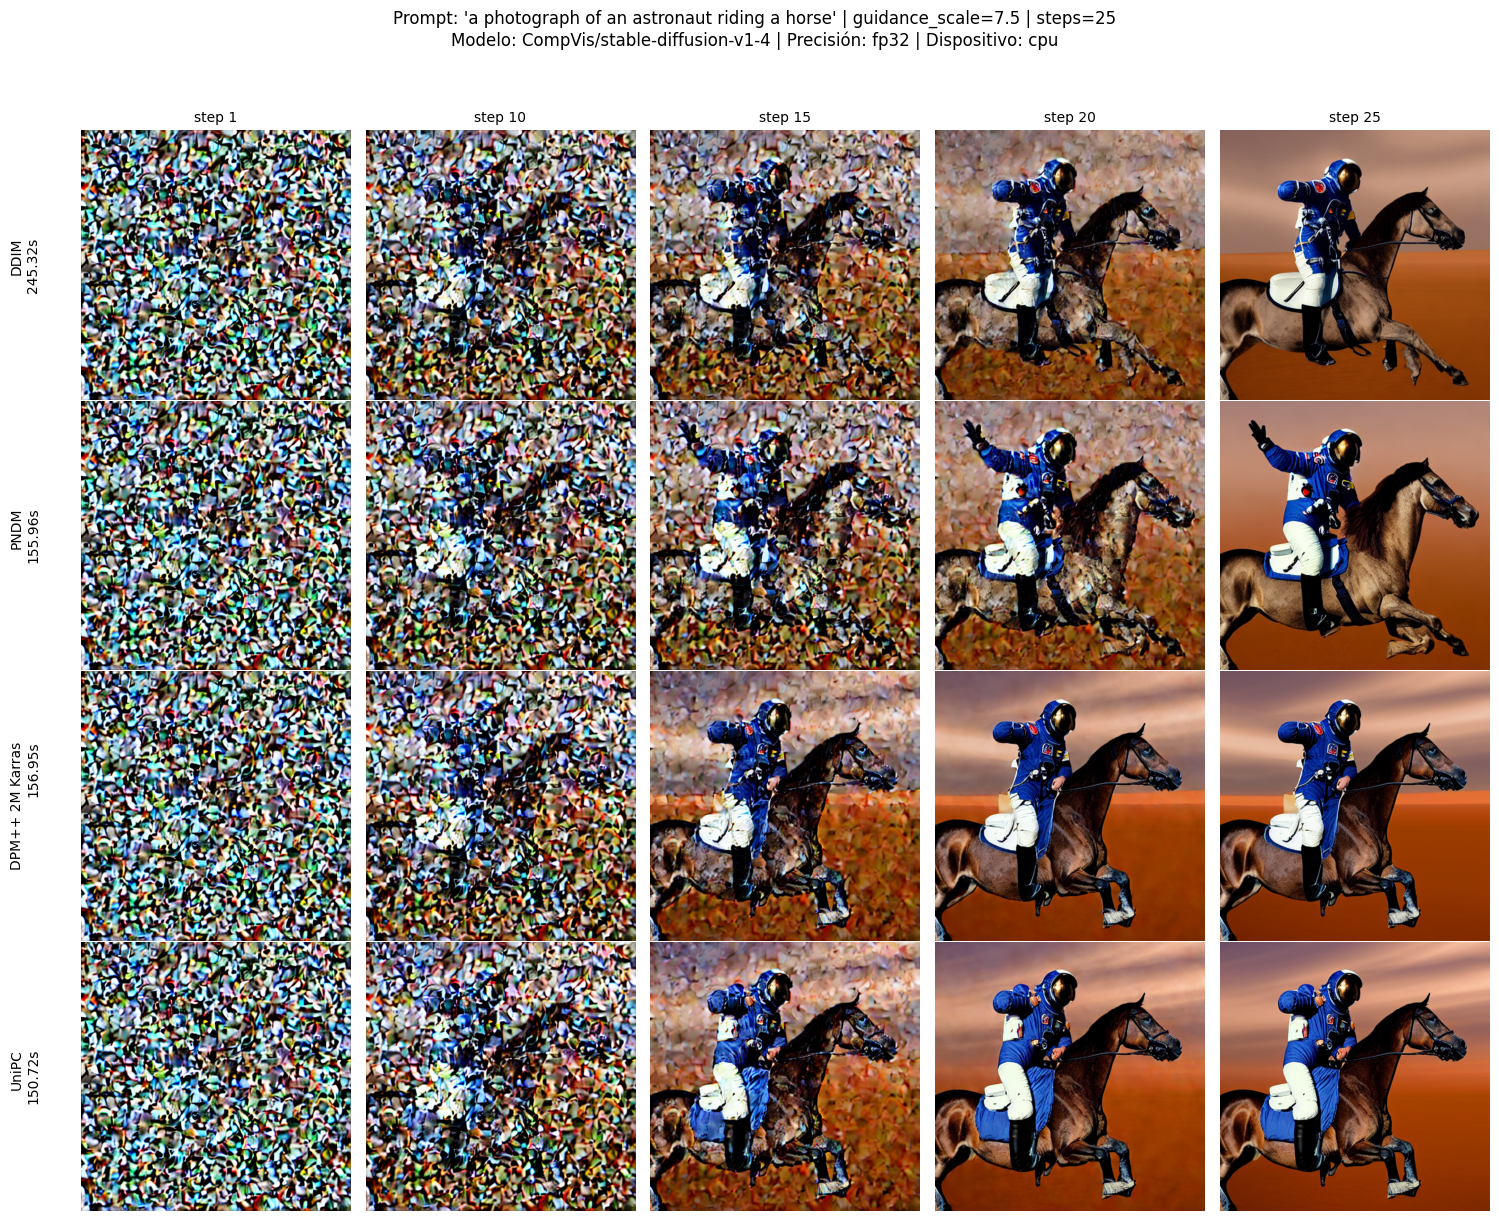

In [37]:
# --- Plot en cuadrícula + metadatos y tiempos ---
row_names = list(schedulers.keys())
n_rows = len(row_names)
n_cols = len(steps_to_show)

fig_w, fig_h = 3.0 * n_cols, 3.2 * n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
import numpy as np
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for r, sched_name in enumerate(row_names):
    for c, step in enumerate(steps_to_show):
        ax = axes[r, c]
        img = samples_by_sched[sched_name].get(step)
        if img is not None:
            ax.imshow(img)
        ax.axis("off")
        if r == 0:
            ax.set_title(f"step {step}", fontsize=10, pad=6)

    # etiqueta lateral con el tiempo total de muestreo
    axes[r, 0].text(
        -0.15, 0.5, f"{sched_name}\n{times_by_sched[sched_name]:.2f}s",
        va="center", ha="right", rotation=90, transform=axes[r, 0].transAxes, fontsize=10
    )

precision_str = (
    "fp16" if torch_dtype == torch.float16 else
    ("bf16" if torch_dtype == torch.bfloat16 else "fp32")
)
title = (
    f"Prompt: '{prompt_str}' | guidance_scale={guidance_scale} | steps={num_inference_steps}\n"
    f"Modelo: {model_id} | Precisión: {precision_str} | Dispositivo: {device_str}"
)

plt.suptitle(title, fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Tarea 8: Vas a calcular una métrica, CLIPScore, para medir la alineación de la imagen generada con el prompt de texto.**

**Nota importante**:  
- CLIPScore mide **coherencia semántica** entre texto e imagen (alineación con el prompt).  
- **No mide calidad perceptual** como:  nitidez, resolución, realismo, estética...  

Referencia de valores CLIPScore

- **< 0.15** → muy débil, casi sin relación entre texto e imagen.  
- **0.15 – 0.25** → relación perceptible pero floja (común en pasos iniciales de difusión).  
- **0.25 – 0.35** → buena coherencia semántica entre imagen y texto.  

En el último tema del primer bloque de la asignatura veremos con mayor detalle esta y otras métricas para evaluar calidad y alineación con las condiciones de generación de imagen.

Por ahora, simplemente vas a completar la celda de abajo para calcular CLIPScore en las muestras obtenidas en los pasos steps_to_show = [1, 10, 15, 20, 25] con el muestreo según *scheduler PNDM*, obteniendo una salida del estilo...

```
=== CLIP Scores (PNDM) ===
Step  1: 0.141
Step 10: 0.167
Step 15: 0.296
Step 20: 0.327
Step 25: 0.337
```



Completa la siguiente celda para calcular las CLIPScores en los pasos de PNDM almacenados:

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# --- Cargar modelo CLIP de Hugging Face ---
clip_model_id = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(clip_model_id).eval()
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

def clip_score(img: Image.Image, text: str) -> float:
    """Calcula CLIPScore entre imagen PIL y texto."""
    inputs = clip_processor(text=[text], images=[img], return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_features = outputs.image_embeds
        text_features  = outputs.text_embeds
    # Normalizamos embeddings - NL2
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)
    # Similaridad coseno
    score = (image_features @ text_features.T).squeeze().item()
    return float(score)

# Tomamos las muestras de PNDM guardadas
pndm_key = "PNDM"
assert pndm_key in samples_by_sched, "No se encontraron muestras PNDM (ejecuta primero la Tarea 7)."

print("=== CLIP Scores (PNDM) ===")
for step in steps_to_show:
    img = samples_by_sched[pndm_key][step]
    score = clip_score(img, prompt)
    print(f"Step {step:>2}: {score:.3f}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--openai--clip-vit-large-patch14. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need 

=== CLIP Scores (PNDM) ===
Step  1: 0.141
Step 10: 0.167
Step 15: 0.291
Step 20: 0.320
Step 25: 0.337
